In [1]:
%env NICKNAME=gind.alex
%env TASK=peaks06.bed

import os
task_filename = os.environ["TASK"]

env: NICKNAME=gind.alex
env: TASK=peaks06.bed


Файл загружен с яндекс диска и скопирован на кодомо через scp

In [2]:
import pandas as pd


bed_columns = ['chrom', 'chromStart', 'chromEnd', 'strand']
df = pd.read_csv(task_filename, sep='\t', names=bed_columns)
df['width'] = df.apply(lambda row: row['chromEnd'] - row['chromStart'], axis=1)
df

,chrom,chromStart,chromEnd,strand,width
0,chr1,779670,779822,.,152
1,chr1,990867,991062,.,195
2,chr1,1000777,1001090,.,313
3,chr1,1013048,1013239,.,191
4,chr1,1044900,1045082,.,182
...,...,...,...,...,...
37469,chrX,155815377,155815527,.,150
37470,chrY,10911577,10911720,.,143
37471,chrY,11311872,11312059,.,187
37472,chrY,11326010,11326205,.,195


<AxesSubplot: ylabel='Frequency'>

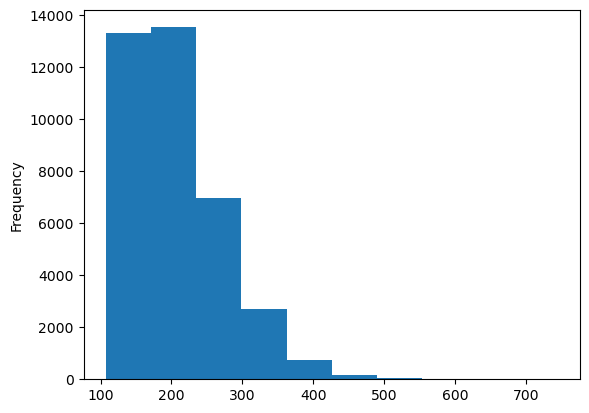

In [3]:
df['width'].plot.hist()

<AxesSubplot: ylabel='Frequency'>

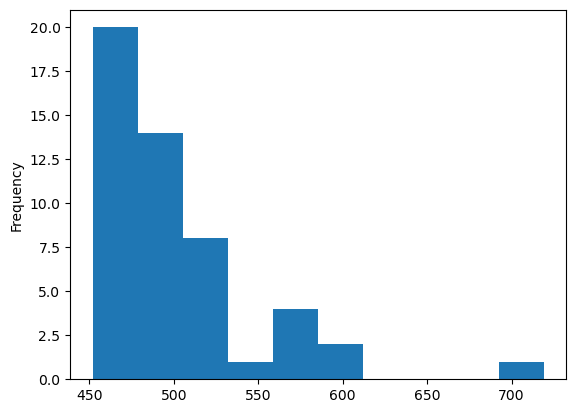

In [4]:
# second f stands for 'filtered'
top_sample = df[df.width > 450].sample(n=50, replace=False)

top_sample['width'].plot.hist()

In [5]:
top_filename = f'top.{task_filename}'
top_sample.to_csv(top_filename, header=False, index=False, sep='\t', columns=bed_columns)

In [6]:
genome_gz_filepath = f'/mnt/scratch/NGS/{os.environ["NICKNAME"]}/GRCh38.p14.genome.fa.gz'

def get_checksum(fp: str) -> str:
    checksum = !md5sum $fp
    return checksum[0].split(' ')[0]

genome_checksum = '46def657b1dda0d2aa6cdec769a196a7'
if get_checksum(genome_gz_filepath) != genome_checksum:
    !wget --timeout=900 -O $genome_gz_filepath 'https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_47/GRCh38.p14.genome.fa.gz'

assert get_checksum(genome_gz_filepath) == genome_checksum

--2024-12-22 00:44:41--  https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_47/GRCh38.p14.genome.fa.gz
Resolving ftp.ebi.ac.uk (ftp.ebi.ac.uk)... 193.62.193.165
Connecting to ftp.ebi.ac.uk (ftp.ebi.ac.uk)|193.62.193.165|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 897322567 (856M) [application/x-gzip]
Saving to: ‘/mnt/scratch/NGS/gind.alex/GRCh38.p14.genome.fa.gz’

/mnt/scratch/NGS/gi 100%[===================>] 855.75M  1.24MB/s    in 11m 34s 

2024-12-22 00:56:16 (1.23 MB/s) - ‘/mnt/scratch/NGS/gind.alex/GRCh38.p14.genome.fa.gz’ saved [897322567/897322567]



In [7]:
genome_filepath = genome_gz_filepath[:-3]
!gzip --quiet --force --stdout --decompress $genome_gz_filepath  > $genome_filepath

In [8]:
peaks_fasta_path = f'top.{task_filename}.fa'
!bedtools getfasta -fi $genome_filepath -bed $top_filename -fo $peaks_fasta_path

index file /mnt/scratch/NGS/gind.alex/GRCh38.p14.genome.fa.fai not found, generating...


In [9]:
meme_dir = f'{peaks_fasta_path}.meme.d'
!/opt/meme-5.5.1/bin/meme-chip \
    -dna \
    -minw 6 \
    -maxw 15 \
    -oc $meme_dir \
    -meme-minsites 2 \
    -meme-maxsites 600 \
    -meme-nmotifs 10 \
    -streme-pvt 0.05 \
    -centrimo-score 5 \
    -centrimo-ethresh 10 \
    $peaks_fasta_path

Starting getsize: getsize top.peaks06.bed.fa.meme.d/top.peaks06.bed.fa 1> $metrics
getsize ran successfully in 0.021361 seconds
Starting fasta-most: fasta-most -min 50 < top.peaks06.bed.fa.meme.d/top.peaks06.bed.fa 1> $metrics
fasta-most ran successfully in 0.074226 seconds
Starting fasta-center: fasta-center -dna -len 100 < top.peaks06.bed.fa.meme.d/top.peaks06.bed.fa 1> top.peaks06.bed.fa.meme.d/seqs-centered
fasta-center ran successfully in 0.140895 seconds
Starting fasta-get-markov: fasta-get-markov -nostatus -nosummary -dna -m 2 top.peaks06.bed.fa.meme.d/top.peaks06.bed.fa top.peaks06.bed.fa.meme.d/background
fasta-get-markov ran successfully in 0.145989 seconds
Starting meme: meme top.peaks06.bed.fa.meme.d/seqs-centered -oc top.peaks06.bed.fa.meme.d/meme_out -mod zoops -nmotifs 10 -minw 6 -maxw 15 -bfile top.peaks06.bed.fa.meme.d/background -dna -minsites 2 -maxsites 600 -revcomp -nostatus
Maximum number of sites is exceeded. Setting to 50.
meme ran successfully in 16.915844 seco

In [10]:
motifs_db_gz_filepath = f'/mnt/scratch/NGS/{os.environ["NICKNAME"]}/meme.motifs.db.12.25.tgz'
motifs_db_checksum = '94e4bc8097bca905ac3c14f244e9f77b'
if get_checksum(motifs_db_gz_filepath) != motifs_db_checksum:
    !wget --timeout=900 -O $motifs_db_gz_filepath 'https://meme-suite.org/meme/meme-software/Databases/motifs/motif_databases.12.25.tgz'

assert get_checksum(motifs_db_gz_filepath) == motifs_db_checksum

--2024-12-22 00:57:21--  https://meme-suite.org/meme/meme-software/Databases/motifs/motif_databases.12.25.tgz
Resolving meme-suite.org (meme-suite.org)... 128.208.8.135
Connecting to meme-suite.org (meme-suite.org)|128.208.8.135|:443... connected.
HTTP request sent, awaiting response... 200 200
Length: unspecified [application/x-gzip]
Saving to: ‘/mnt/scratch/NGS/gind.alex/meme.motifs.db.12.25.tgz’

/mnt/scratch/NGS/gi     [                 <=>]  40.38M  10.4MB/s    in 3.9s    

2024-12-22 00:57:26 (10.4 MB/s) - ‘/mnt/scratch/NGS/gind.alex/meme.motifs.db.12.25.tgz’ saved [42345776]



In [11]:
motifs_db_filepath = f'/mnt/scratch/NGS/{os.environ["NICKNAME"]}/meme.motifs.db.d'
!mkdir -p $motifs_db_filepath
!tar -xzf $motifs_db_gz_filepath -C $motifs_db_filepath
hocomoco_filepath = motifs_db_filepath + '/motif_databases/HOCOMOCO/H12CORE_meme_format.meme'

tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.quarantine'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.metadata:kMDItemWhereFroms'


In [12]:
!/opt/meme-5.5.1/bin/tomtom \
    -oc $meme_dir/streme_tomtom_out.d \
    -min-overlap 5 \
    -dist pearson \
    -evalue \
    -thresh 1 \
    -no-ssc \
    $meme_dir/streme_out/streme.xml \
    $hocomoco_filepath

Writing results to output directory 'top.peaks06.bed.fa.meme.d/streme_tomtom_out.d'.
Processing query 1 out of 4 
# Computing q-values.
#   Estimating pi_0 from all 2886 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.993881
#   Estimated pi_0=0.993881
Processing query 2 out of 4 
# Computing q-values.
#   Estimating pi_0 from all 2886 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00328
#   Estimated pi_0=1
Processing query 3 out of 4 
# Computing q-values.
#   Estimating pi_0 from all 2886 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.994597
#   Estimated pi_0=0.996319
Processing query 4 out of 4 
# Computing q-values.
#   Estimating pi_0 from all 2886 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00398
#   Estimated pi_0=1


In [14]:
tomtom = pd.read_csv(f'{meme_dir}/streme_tomtom_out.d/tomtom.tsv', sep='\t', comment='#')
tomtom.sort_values(by=['p-value'])
tomtom

,Query_ID,Target_ID,Optimal_offset,p-value,E-value,q-value,Overlap,Query_consensus,Target_consensus,Orientation
0,1-ATTGCACAAYMH,CEBPB.H12CORE.0.P.B,0,7.173220e-08,0.000104,0.000206,11,ATTGCACAACAC,ATTGCGCAACC,-
1,1-ATTGCACAAYMH,CEBPE.H12CORE.0.P.B,0,2.352890e-07,0.000340,0.000337,11,ATTGCACAACAC,ATTGCACAACC,-
2,1-ATTGCACAAYMH,CEBPA.H12CORE.0.P.B,1,7.034690e-07,0.001015,0.000626,11,ATTGCACAACAC,TATTGCGCAACC,-
3,1-ATTGCACAAYMH,CEBPD.H12CORE.0.P.B,1,8.726080e-07,0.001259,0.000626,10,ATTGCACAACAC,GATTGCACAAT,+
4,1-ATTGCACAAYMH,CEBPB.H12CORE.1.SM.B,1,2.203040e-06,0.003179,0.001001,12,ATTGCACAACAC,CATTGCGCAACCC,+
5,1-ATTGCACAAYMH,CEBPD.H12CORE.1.SM.B,1,2.203040e-06,0.003179,0.001001,12,ATTGCACAACAC,AATTACGCAATAC,-
6,1-ATTGCACAAYMH,CEBPG.H12CORE.0.P.B,1,2.443510e-06,0.003526,0.001001,11,ATTGCACAACAC,TATTGCGTAATA,+
7,1-ATTGCACAAYMH,CEBPE.H12CORE.1.SM.B,1,5.756210e-06,0.008306,0.002064,12,ATTGCACAACAC,CGTTGCGCAATCC,+
8,1-ATTGCACAAYMH,CEBPG.H12CORE.1.SM.B,1,4.542580e-05,0.065549,0.012937,11,ATTGCACAACAC,TATTGCGTAATA,+
9,1-ATTGCACAAYMH,NFIL3.H12CORE.0.P.B,0,8.334230e-05,0.120263,0.019921,10,ATTGCACAACAC,GTTACATAAC,-


In [43]:
import json
from IPython import display


best_match = tomtom['Target_ID'][0]
hocomoco_link = f'https://hocomoco12.autosome.org/motif/{best_match}#maininfo'
uniprot_accessions = !curl -s $hocomoco_link -o - | grep 'UniProt AC' | grep -oP '\?uniprot=[a-zA-Z0-9]+' | cut -d '=' -f 2

uniprot_infos = []
for acc in uniprot_accessions:
    body = !curl -s -H "Accept: application/json" "https://rest.uniprot.org/uniprotkb/$acc"
    res = json.loads(body[0])
    info = {
        'acc': acc,
        'id': res.get('uniProtkbId'),
        'pdb': [],
        'supfam': [],
        'supfam_names': set(),
    }
    for desc in res.get('uniProtKBCrossReferences', []):
        if 'database' in desc and desc['database'] == 'PDB':
            info['pdb'].append(desc.get('id', ''))
        elif 'database' in desc and desc['database'] == 'SUPFAM':
            supfam = {'id': desc.get('id', '')}
            for prop in desc.get('properties', []):
                if prop.get('key') == 'EntryName':
                    supfam['name'] = prop.get('value', '')
                    info['supfam_names'].add(prop.get('value', ''))
                    break
            info['supfam'].append(supfam)
    uniprot_infos.append(info)

table = """|accession|id|supfam|pdb|
|--|--|--|--|
"""
for info in uniprot_infos:
    table += f'|{info["acc"]}|{info["id"]}|{info["supfam_names"]}|{info["pdb"]}|\n'
display.display_markdown(table, raw=True)

|accession|id|supfam|pdb|
|--|--|--|--|
|P17676|CEBPB_HUMAN|{'Leucine zipper domain'}|['1GTW', '1GU4', '1GU5', '1H88', '1H89', '1H8A', '1HJB', '1IO4', '2E42', '2E43', '6MG1', '6MG2', '6MG3', '7L4V', '7UPZ', '8K8D']|
|P28033|CEBPB_MOUSE|{'Leucine zipper domain'}|['1CI6']|
